If the Glove file is not in the directory. Otherwise skip the command line section.

In [ ]:
!wget "http://nlp.stanford.edu/data/glove.twitter.27B.zip"
!unzip -j glove.twitter.27B.zip

# Multilayered LSTM with Class Weights

In [3]:
import pandas as pd
import glob
import json
import numpy as np
import nltk
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Conv1D
from keras.layers import MaxPool1D
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Dropout
from keras.layers import SpatialDropout1D
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

Using TensorFlow backend.


In [4]:
classified = pd.read_csv('cleaned_data.csv')

Clean up by dropping any NaN vals, label/clean up columns:

In [5]:
classified = classified[['label','text']]
classified.text = classified.text.astype(str)
classified.head()

,label,text
0,0.0,in my personal opinion if you plan on committi...
1,0.0,they really going to allow the hashtag clinton...
2,0.0,that feel when you cant wait for work to be ov...
3,0.0,so let it be said that amonute matoaka powhata...
4,3.0,also your turn to die is now officially finish...


In [6]:
embeddings_idx = dict()
glove_file = open('glove.twitter.27B.100d.txt')
for line in glove_file:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_idx[word] = coefs
glove_file.close()
print('Loaded %s word vectors.' % len(embeddings_idx))

Loaded 1193514 word vectors.


For simplicity, clump "depressed" and "suicidal" labels into one category (can refine this in future models/iteration; for first iteration, use binary classification):

In [7]:
text = np.asarray(classified.text)
labels_binary = classified.label.replace(to_replace=3, value=1)
label = np.asarray(classified.label)

np.unique(labels_binary)

array([0., 1.])

Tokenize tweet texts. Use a max sentence length of 50 (with char limit of 280 and cleaning, this seems reasonable - by observation, most tweets still require padding), and pad all tweets out to this length:

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text)
vocab_size = len(tokenizer.word_index) + 1
# integer encode the documents
encoded = tokenizer.texts_to_sequences(text)
# pad documents to a max length of 4 words
max_length = 50
padded_tweets = pad_sequences(encoded, maxlen=max_length, padding='post')
padded_tweets

array([[  9,   8, 800, ...,   0,   0,   0],
       [ 34,  88,  90, ...,   0,   0,   0],
       [ 14, 100,  53, ...,   0,   0,   0],
       ...,
       [ 31,  18, 777, ...,   0,   0,   0],
       [686, 195,  12, ...,   0,   0,   0],
       [378,  10, 986, ...,   0,   0,   0]], dtype=int32)

Split into train/val set of 90%/10%; next step is to try k-fold val (small dataset):

In [9]:
text_train, text_test, label_train, label_test = train_test_split(padded_tweets, labels_binary, test_size = 0.1, random_state = 0)

Initialize embedding matrix to seed embedding weights from the loaded GloVe embeddings:


In [10]:
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_idx.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Recall is extremely useful in such a problem where all efforts to avert a potential suicide is of utmost importance

In [11]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

Plot the history to see where the validation accuracy peaks:

In [12]:
def print_history_graph(history):
    import matplotlib.pyplot as plt
    %matplotlib inline
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    recall = history.history['val_recall_m']
    epochs = range(1, len(acc)+1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.plot(epochs, recall, 'r', label='Recall')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend()
    plt.show()
    print(val_acc)
    
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# LSTM with class weights

## Model 1
Three LSTM layers (64, 128, 64) and class weights 3x for 'depressed/suicide' class

In [13]:
lstm_model_2layers_m1 = Sequential()
lstm_model_2layers_m1.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=50, trainable=True))
lstm_model_2layers_m1.add(SpatialDropout1D(0.2))
lstm_model_2layers_m1.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2,return_sequences=True))
lstm_model_2layers_m1.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2,return_sequences=True))
lstm_model_2layers_m1.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
lstm_model_2layers_m1.add(Dense(1, activation='sigmoid'))
lstm_model_2layers_m1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',recall_m ])


W0804 13:07:41.602766 4485481920 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0804 13:07:41.622445 4485481920 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0804 13:07:41.625242 4485481920 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0804 13:07:41.633942 4485481920 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:17

In [14]:
lstm_model_2layers_m1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           2042500   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 64)            42240     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 128)           98816     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 2,233,029
Trainable params: 2,233,029
Non-trainable params: 0
_________________________________________________________________


In [15]:
lstm_model_2layers_m1_history = lstm_model_2layers_m1.fit(
    text_train, label_train, batch_size = 32, 
    validation_data = (text_test, label_test), epochs=100,
    callbacks=[EarlyStopping(monitor='val_loss', patience=4, min_delta=0.0001)],
    verbose=1,
    class_weight={0:1.,1:3.}
)

Train on 10384 samples, validate on 1154 samples
Epoch 1/100
10384/10384 [==============================] - 75s 7ms/step - loss: 0.8954 - acc: 0.6653 - recall_m: 0.6473 - val_loss: 0.5865 - val_acc: 0.6820 - val_recall_m: 0.7230
Epoch 2/100
10384/10384 [==============================] - 71s 7ms/step - loss: 0.8184 - acc: 0.6996 - recall_m: 0.7403 - val_loss: 0.5521 - val_acc: 0.6941 - val_recall_m: 0.7788
Epoch 3/100
10384/10384 [==============================] - 71s 7ms/step - loss: 0.7774 - acc: 0.7296 - recall_m: 0.7486 - val_loss: 0.5116 - val_acc: 0.7348 - val_recall_m: 0.6497
Epoch 4/100
10384/10384 [==============================] - 71s 7ms/step - loss: 0.7383 - acc: 0.7536 - recall_m: 0.7649 - val_loss: 0.5169 - val_acc: 0.7383 - val_recall_m: 0.6968
Epoch 5/100
10384/10384 [==============================] - 71s 7ms/step - loss: 0.6960 - acc: 0.7580 - recall_m: 0.8258 - val_loss: 0.4944 - val_acc: 0.7504 - val_recall_m: 0.5844
Epoch 6/100
10384/10384 [==========================

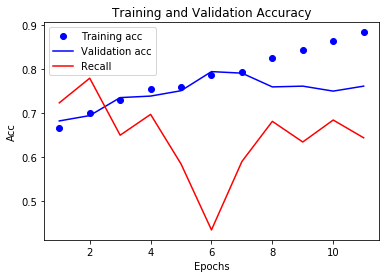

[0.6819757365684576, 0.6941074523396881, 0.7348353552859619, 0.7383015597920277, 0.7504332755632582, 0.7937608318890814, 0.7902946273830156, 0.7590987868284229, 0.7608318890814558, 0.7495667244367418, 0.7608318890814558]


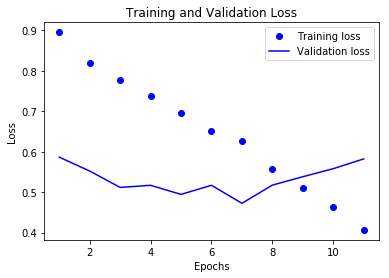

In [28]:
print_history_graph(lstm_model_2layers_m1_history)

## Model 2
Same model as M1 but 2x class weights intead of 3x {Three LSTM layers (64, 128, 64) and class weights 2x for 'depressed/suicide' class}

In [29]:
lstm_model_2layers_m2_history = lstm_model_2layers_m1.fit(iStopping(monitor='val_loss', patience=4, min_delta=0.0001)],
    verbose=1,
    class_weight={0:1.,1:2.}
)

Train on 10384 samples, validate on 1154 samples
Epoch 1/100
10384/10384 [==============================] - 71s 7ms/step - loss: 0.3162 - acc: 0.8971 - recall_m: 0.8768 - val_loss: 0.5185 - val_acc: 0.7929 - val_recall_m: 0.5498
Epoch 2/100
10384/10384 [==============================] - 71s 7ms/step - loss: 0.2920 - acc: 0.9115 - recall_m: 0.8866 - val_loss: 0.5957 - val_acc: 0.7825 - val_recall_m: 0.6109
Epoch 3/100
10384/10384 [==============================] - 71s 7ms/step - loss: 0.2734 - acc: 0.9161 - recall_m: 0.9067 - val_loss: 0.5544 - val_acc: 0.7964 - val_recall_m: 0.5467
Epoch 4/100
10384/10384 [==============================] - 71s 7ms/step - loss: 0.2575 - acc: 0.9201 - recall_m: 0.9024 - val_loss: 0.6373 - val_acc: 0.7894 - val_recall_m: 0.5795
Epoch 5/100
10384/10384 [==============================] - 71s 7ms/step - loss: 0.2493 - acc: 0.9249 - recall_m: 0.9208 - val_loss: 0.6195 - val_acc: 0.7964 - val_recall_m: 0.5423


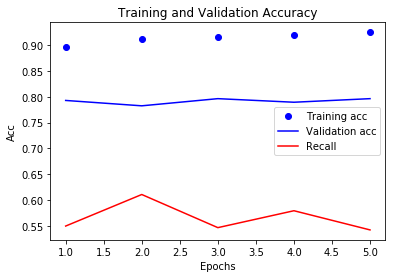

[0.792894280762565, 0.7824956672443674, 0.7963604852686309, 0.7894280762564991, 0.7963604852686309]


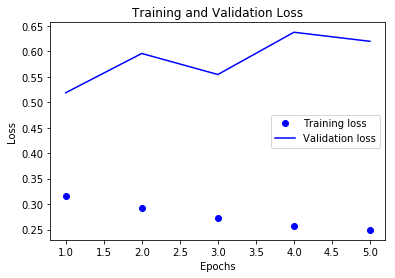

In [31]:
print_history_graph(lstm_model_2layers_m2_history)

### Model 1 vs Model 2 comparision:

We get an increase of 10% in recall at the cost of 5% reduction in accuracy with model 1. Model 1 is preferred because of higher recall.


**Current Champion Model (Model 1): 76% Accuracy, 64% recall**

## Model 3
Wider netowrk - Three LSTM layers (64, 128, 256) and class weights 3x for 'depressed/suicide' class

In [34]:
lstm_model_2layers_m3 = Sequential()
lstm_model_2layers_m3.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=50, trainable=True))
lstm_model_2layers_m3.add(SpatialDropout1D(0.2))
lstm_model_2layers_m3.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2,return_sequences=True))
lstm_model_2layers_m3.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2,return_sequences=True))
lstm_model_2layers_m3.add(LSTM(256, dropout=0.2, recurrent_dropout=0.2))
lstm_model_2layers_m3.add(Dense(1, activation='sigmoid'))
lstm_model_2layers_m3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',recall_m ])
lstm_model_2layers_m3.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 100)           2080600   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 50, 100)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 50, 64)            42240     
_________________________________________________________________
lstm_11 (LSTM)               (None, 50, 128)           98816     
_________________________________________________________________
lstm_12 (LSTM)               (None, 256)               394240    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 2,616,153
Trainable params: 2,616,153
Non-trainable params: 0
_________________________________________________________________


In [35]:
lstm_model_2layers_m3_history = lstm_model_2layers_m3.fit(
    text_train, label_train, batch_size = 32, 
    validation_data = (text_test, label_test), epochs=100,
    callbacks=[EarlyStopping(monitor='val_loss', patience=4, min_delta=0.0001)],
    verbose=1,
    class_weight={0:1.,1:3.}
)

Train on 10384 samples, validate on 1154 samples
Epoch 1/100
10384/10384 [==============================] - 118s 11ms/step - loss: 0.8840 - acc: 0.6722 - recall_m: 0.6593 - val_loss: 0.5623 - val_acc: 0.6984 - val_recall_m: 0.7488
Epoch 2/100
10384/10384 [==============================] - 112s 11ms/step - loss: 0.8116 - acc: 0.7164 - recall_m: 0.7090 - val_loss: 0.5456 - val_acc: 0.7097 - val_recall_m: 0.7464
Epoch 3/100
10384/10384 [==============================] - 112s 11ms/step - loss: 0.7835 - acc: 0.7226 - recall_m: 0.7639 - val_loss: 0.5587 - val_acc: 0.6785 - val_recall_m: 0.8112
Epoch 4/100
10384/10384 [==============================] - 113s 11ms/step - loss: 0.7414 - acc: 0.7497 - recall_m: 0.7962 - val_loss: 0.4912 - val_acc: 0.7496 - val_recall_m: 0.6252
Epoch 5/100
10384/10384 [==============================] - 112s 11ms/step - loss: 0.7772 - acc: 0.7793 - recall_m: 0.6148 - val_loss: 0.5364 - val_acc: 0.7790 - val_recall_m: 0.3820
Epoch 6/100
10384/10384 [================

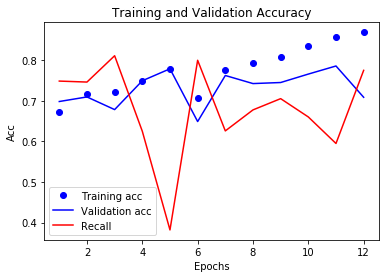

[0.6984402079722704, 0.7097053726169844, 0.6785095320623917, 0.7495667244367418, 0.7790294627383015, 0.6490467937608319, 0.7625649913344887, 0.74263431542461, 0.7452339688041595, 0.7660311958405546, 0.7859618717504333, 0.708838821490468]


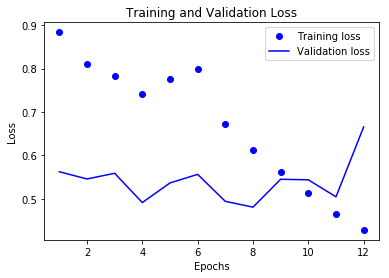

In [36]:
print_history_graph(lstm_model_2layers_m3_history)

### Model 1 vs Model 3 comparision:

Model 3 and Model 1 are very similar. Choose Model 3 over Model 1 as Model 3 has a higher and conistent recall. Will keep the benchmark for the champion model at approx 75% accuracy and 65% recall.

# Model 4
Adding a flat, dense layer after the RNN layers

In [37]:
lstm_model_2layers_m4 = Sequential()
lstm_model_2layers_m4.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=50, trainable=True))
lstm_model_2layers_m4.add(SpatialDropout1D(0.2))
lstm_model_2layers_m4.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2,return_sequences=True))
lstm_model_2layers_m4.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2,return_sequences=True))
lstm_model_2layers_m4.add(LSTM(256, dropout=0.2, recurrent_dropout=0.2))
lstm_model_2layers_m4.add(Dense(10, activation='relu'))
lstm_model_2layers_m4.add(Dense(1, activation='sigmoid'))
lstm_model_2layers_m4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',recall_m ])
lstm_model_2layers_m4.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 50, 100)           2080600   
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 50, 100)           0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 50, 64)            42240     
_________________________________________________________________
lstm_14 (LSTM)               (None, 50, 128)           98816     
_________________________________________________________________
lstm_15 (LSTM)               (None, 256)               394240    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                2570      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total para

In [38]:
lstm_model_2layers_m4_history = lstm_model_2layers_m4.fit(
    text_train, label_train, batch_size = 32, 
    validation_data = (text_test, label_test), epochs=100,
    callbacks=[EarlyStopping(monitor='val_loss', patience=4, min_delta=0.0001)],
    verbose=1,
    class_weight={0:1.,1:3.}
)

Train on 10384 samples, validate on 1154 samples
Epoch 1/100
10384/10384 [==============================] - 118s 11ms/step - loss: 0.8940 - acc: 0.6736 - recall_m: 0.6331 - val_loss: 0.5265 - val_acc: 0.7218 - val_recall_m: 0.6659
Epoch 2/100
10384/10384 [==============================] - 112s 11ms/step - loss: 0.8141 - acc: 0.6833 - recall_m: 0.7726 - val_loss: 0.5412 - val_acc: 0.6915 - val_recall_m: 0.7479
Epoch 3/100
10384/10384 [==============================] - 112s 11ms/step - loss: 0.7947 - acc: 0.7361 - recall_m: 0.7453 - val_loss: 0.5649 - val_acc: 0.6776 - val_recall_m: 0.8245
Epoch 4/100
10384/10384 [==============================] - 112s 11ms/step - loss: 0.8029 - acc: 0.7090 - recall_m: 0.7255 - val_loss: 0.4900 - val_acc: 0.7444 - val_recall_m: 0.6120
Epoch 5/100
10384/10384 [==============================] - 113s 11ms/step - loss: 0.7467 - acc: 0.7517 - recall_m: 0.7854 - val_loss: 0.5568 - val_acc: 0.6586 - val_recall_m: 0.7937
Epoch 6/100
10384/10384 [================

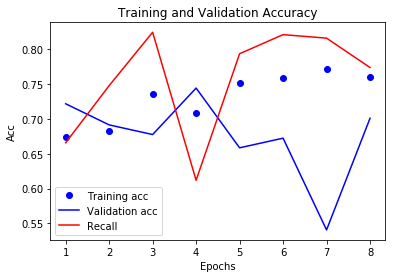

[0.7218370883882149, 0.6915077989601387, 0.6776429809358753, 0.744367417677643, 0.658578856152513, 0.6724436741767764, 0.5407279029462738, 0.7010398613518197]


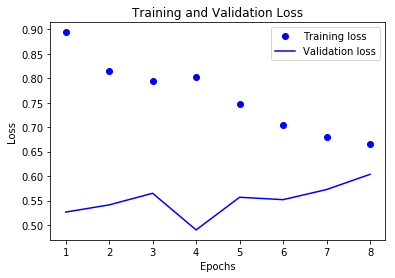

In [39]:
print_history_graph(lstm_model_2layers_m4_history)

### Model 3 vs Model 4 comparision:

Model 4 gives about 12% increase in recall (at 77%) compared to Model 3, but the accuracy is lower by about 5% (at ~70%). Prefer Model 4 over model 3 (judgment call)

# Model 5
Adding bidrectional layers 

In [41]:
lstm_model_2layers_m5 = Sequential()
lstm_model_2layers_m5.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=50, trainable=True))
lstm_model_2layers_m5.add(SpatialDropout1D(0.2))
lstm_model_2layers_m5.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2,return_sequences=True)))
lstm_model_2layers_m5.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2,return_sequences=True)))
lstm_model_2layers_m5.add(Bidirectional(LSTM(256, dropout=0.2, recurrent_dropout=0.2)))
lstm_model_2layers_m5.add(Dense(1, activation='sigmoid'))
lstm_model_2layers_m5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',recall_m ])
lstm_model_2layers_m5.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 50, 100)           2080600   
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 50, 100)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 128)           84480     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 50, 256)           263168    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 512)               1050624   
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 513       
Total params: 3,479,385
Trainable params: 3,479,385
Non-trainable params: 0
_________________________________________________________________


In [42]:
lstm_model_2layers_m5_history = lstm_model_2layers_m5.fit(
    text_train, label_train, batch_size = 32, 
    validation_data = (text_test, label_test), epochs=100,
    callbacks=[EarlyStopping(monitor='val_loss', patience=4, min_delta=0.0001)],
    verbose=1,
    class_weight={0:1.,1:3.}
)

Train on 10384 samples, validate on 1154 samples
Epoch 1/100
10384/10384 [==============================] - 270s 26ms/step - loss: 0.8478 - acc: 0.6823 - recall_m: 0.6748 - val_loss: 0.5069 - val_acc: 0.7426 - val_recall_m: 0.6826
Epoch 2/100
10384/10384 [==============================] - 259s 25ms/step - loss: 0.7626 - acc: 0.7366 - recall_m: 0.7269 - val_loss: 0.4940 - val_acc: 0.7695 - val_recall_m: 0.5926
Epoch 3/100
10384/10384 [==============================] - 258s 25ms/step - loss: 0.6907 - acc: 0.7697 - recall_m: 0.7782 - val_loss: 0.4878 - val_acc: 0.7496 - val_recall_m: 0.7305
Epoch 4/100
10384/10384 [==============================] - 258s 25ms/step - loss: 0.6314 - acc: 0.7955 - recall_m: 0.7992 - val_loss: 0.4738 - val_acc: 0.7704 - val_recall_m: 0.6707
Epoch 5/100
10384/10384 [==============================] - 257s 25ms/step - loss: 0.5381 - acc: 0.8311 - recall_m: 0.8397 - val_loss: 0.4895 - val_acc: 0.7660 - val_recall_m: 0.6255
Epoch 6/100
10384/10384 [================

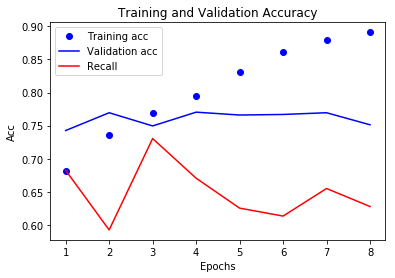

[0.74263431542461, 0.7694974003466204, 0.7495667244367418, 0.770363951473137, 0.7660311958405546, 0.766897746967071, 0.7694974003466204, 0.7512998266897747]


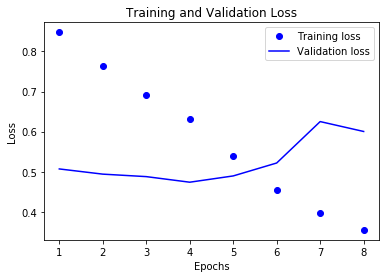

In [43]:
print_history_graph(lstm_model_2layers_m5_history)

### Model 5 vs Model 3 comparision:

Model 3 is better is better is at has a higher recall.

# Final Model

Model 3 is the best model. It's an LSTM with 3 layers (64, 128 and 256 units) and 3x weighting of the class. Below is a the performance.

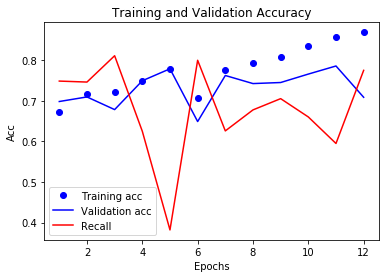

[0.6984402079722704, 0.7097053726169844, 0.6785095320623917, 0.7495667244367418, 0.7790294627383015, 0.6490467937608319, 0.7625649913344887, 0.74263431542461, 0.7452339688041595, 0.7660311958405546, 0.7859618717504333, 0.708838821490468]


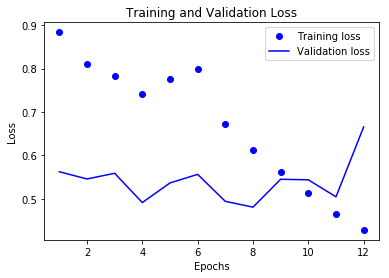

In [44]:
print_history_graph(lstm_model_2layers_m3_history)